# Imports

In [2]:
import numpy as np
from scipy.spatial import distance_matrix
import torch
from torch import nn
import matplotlib.pyplot as plt
import math
import os
import gpytorch
from scipy import optimize

# A Simple Gaussian Process

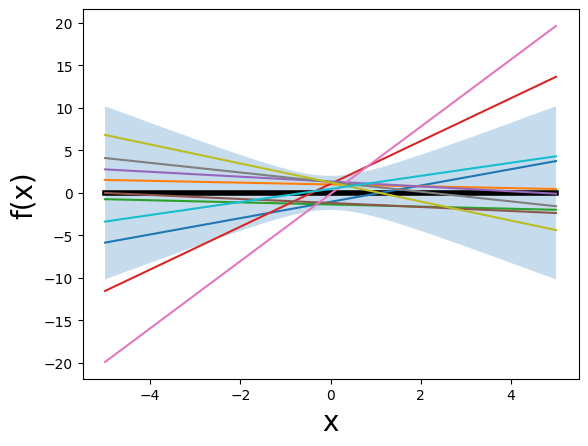

In [3]:
def lin_func(x, n_sample):
    preds = np.zeros((n_sample, x.shape[0]))
    for ii in range(n_sample):
        w = np.random.normal(0, 1, 2)
        y = w[0] + w[1] * x
        preds[ii, :] = y
    return preds

x_points = np.linspace(-5, 5, 50)
outs = lin_func(x_points, 10)
lw_bd = -2 * np.sqrt((1 + x_points ** 2))
up_bd = 2 * np.sqrt((1 + x_points ** 2))

plt.fill_between(x_points, lw_bd, up_bd, alpha=0.25)
plt.plot(x_points, np.zeros(len(x_points)), linewidth=4, color='black')
plt.plot(x_points, outs.T)
plt.xlabel("x", fontsize=20)
plt.ylabel("f(x)", fontsize=20)
plt.show()

# The Radial Basis Function (RBF) Kernel 

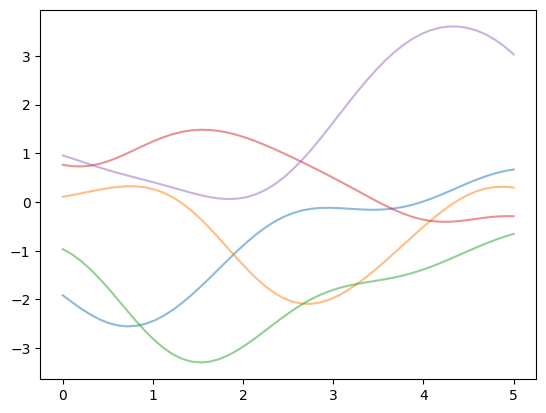

In [4]:
def rbfkernel(x1, x2, ls = 4.):
    dist = distance_matrix(np.expand_dims(x1, axis = 1), np.expand_dims(x2, axis = 1))
    return np.exp(-(1. / ls / 2) * (dist ** 2))

x_points = np.linspace(0, 5, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points, x_points, 1)

prior_samples = np.random.multivariate_normal(meanvec, covmat, size=5)

plt.plot(x_points, prior_samples.T, alpha = 0.5)
plt.show()


# Gaussian Process Inference

## Posterior Inference for Regression

We use example $y = sin(x) + \frac{1}{2} sin(4x) + \epsilon$ with $\epsilon \sim \mathcal{N}(0, \sigma^2)$. The noise free function we wish to find is $f(x) = sin(x) + \frac{1}{2} sin(4x)$. We will use $\sigma = 0.25$

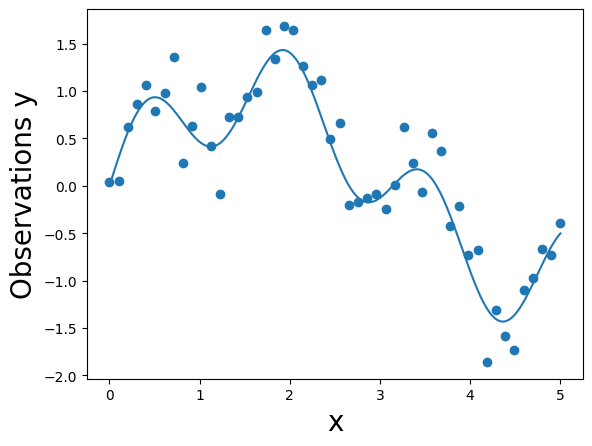

In [5]:
def data_maker1(x, sig):
    return np.sin(x) + 0.5 * np.sin(4 * x) + np.random.randn(x.shape[0]) * sig

sig = 0.25
train_x, test_x = np.linspace(0, 5, 50), np.linspace(0, 5, 500)
train_y, test_y = data_maker1(train_x, sig=sig), data_maker1(test_x, sig=0.)

plt.scatter(train_x, train_y)
plt.plot(test_x, test_y)
plt.xlabel("x", fontsize=20)
plt.ylabel("Observations y", fontsize=20)
plt.show()

In [7]:
mean = np.zeros(test_x.shape[0])
cov = rbfkernel(test_x, test_x, ls=0.2)

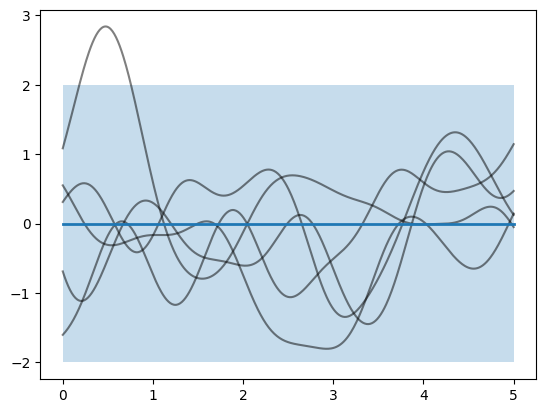

In [8]:
prior_samples = np.random.multivariate_normal(mean=mean, cov=cov, size=5)
plt.plot(test_x, prior_samples.T, color='black', alpha=0.5)
plt.plot(test_x, mean, linewidth=2.)
plt.fill_between(test_x, mean - 2 * np.diag(cov), mean + 2 * np.diag(cov),
                 alpha=0.25)
plt.show()

In [10]:
ell_est = 0.4
post_sig_est = 0.5

def neg_MLL(pars):
    K = rbfkernel(train_x, train_x, ls=pars[0])
    kernel_term = -0.5 * train_y @ \
        np.linalg.inv(K + pars[1] ** 2 * np.eye(train_x.shape[0])) @ train_y
    logdet = -0.5 * np.log(np.linalg.det(K + pars[1] ** 2 * \
                                         np.eye(train_x.shape[0])))
    const = -train_x.shape[0] / 2. * np.log(2 * np.pi)

    return -(kernel_term + logdet + const)


learned_hypers = optimize.minimize(neg_MLL, x0=np.array([ell_est,post_sig_est]),
                                   bounds=((0.01, 10.), (0.01, 10.)))
ell = learned_hypers.x[0]
post_sig_est = learned_hypers.x[1]

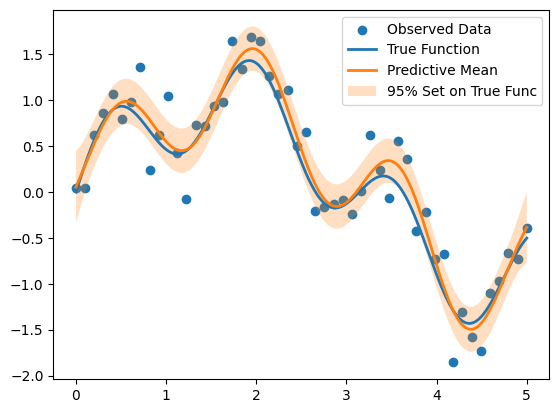

In [11]:
K_x_xstar = rbfkernel(train_x, test_x, ls=ell)
K_x_x = rbfkernel(train_x, train_x, ls=ell)
K_xstar_xstar = rbfkernel(test_x, test_x, ls=ell)

post_mean = K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ train_y
post_cov = K_xstar_xstar - K_x_xstar.T @ np.linalg.inv((K_x_x + \
                post_sig_est ** 2 * np.eye(train_x.shape[0]))) @ K_x_xstar

lw_bd = post_mean - 2 * np.sqrt(np.diag(post_cov))
up_bd = post_mean + 2 * np.sqrt(np.diag(post_cov))

plt.scatter(train_x, train_y)
plt.plot(test_x, test_y, linewidth=2.)
plt.plot(test_x, post_mean, linewidth=2.)
plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(['Observed Data', 'True Function', 'Predictive Mean', '95% Set on True Func'])
plt.show()

In [12]:
lw_bd_observed = post_mean - 2 * np.sqrt(np.diag(post_cov) + post_sig_est ** 2)
up_bd_observed = post_mean + 2 * np.sqrt(np.diag(post_cov) + post_sig_est ** 2)

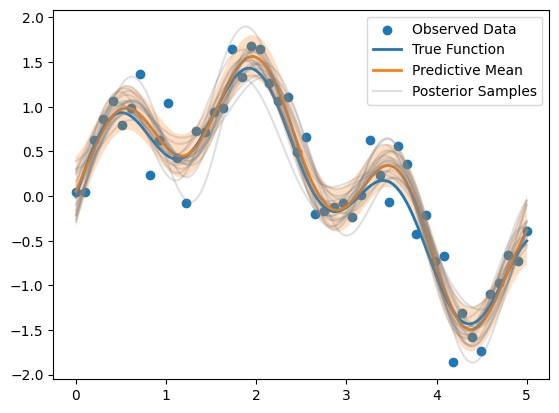

In [13]:
post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)
plt.scatter(train_x, train_y)
plt.plot(test_x, test_y, linewidth=2.)
plt.plot(test_x, post_mean, linewidth=2.)
plt.plot(test_x, post_samples.T, color='gray', alpha=0.25)
plt.fill_between(test_x, lw_bd, up_bd, alpha=0.25)
plt.legend(['Observed Data', 'True Function', 'Predictive Mean', 'Posterior Samples'])
plt.show()

## Leveraging GPyTorch

In [14]:
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [15]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 50
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [16]:
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i+1:d}/{training_iter:d} - Loss: {loss.item():.3f} '
              f'squared lengthscale: '
              f'{model.covar_module.base_kernel.lengthscale.item():.3f} '
              f'noise variance: {model.likelihood.noise.item():.3f}')
    optimizer.step()

Iter 1/50 - Loss: 1.027 squared lengthscale: 0.693 noise variance: 0.693
Iter 11/50 - Loss: 0.753 squared lengthscale: 0.458 noise variance: 0.312
Iter 21/50 - Loss: 0.540 squared lengthscale: 0.502 noise variance: 0.129
Iter 31/50 - Loss: 0.500 squared lengthscale: 0.511 noise variance: 0.065
Iter 41/50 - Loss: 0.504 squared lengthscale: 0.516 noise variance: 0.061


In [17]:
test_x = torch.tensor(test_x)
model.eval()
likelihood.eval()
observed_pred = likelihood(model(test_x))

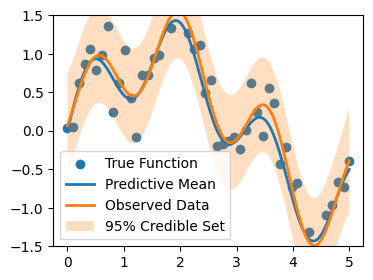

In [18]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower bounds for 95\% credible set (in this case, in
    # observation space)
    lower, upper = observed_pred.confidence_region()
    ax.scatter(train_x.numpy(), train_y.numpy())
    ax.plot(test_x.numpy(), test_y.numpy(), linewidth=2.)
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), linewidth=2.)
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.25)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(['True Function', 'Predictive Mean', 'Observed Data',
               '95% Credible Set'])